# SVM Ordinal Classification

In [1]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from autocorrect import Speller
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, classification_report
import scipy.stats
import math
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import myutils as myutils

spell = Speller(lang='en')
nltk.download('stopwords')
nltk.download('punkt')
tk = RegexpTokenizer(r'\w+')


schemas = ["vulnerable", "angry", "impulsive", "happy", "detached", "punishing", "healthy"]
num_of_schemas = 7
max_words = 2000
max_epochs = 30
vec_size = 500

C:\Users\Irene Park\anaconda3\envs\ResearchProject\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# SVM Ordinal Classification
Functions below has been used for ordinal classification and has been inspired by Burger Franziska.

In [2]:

#SVM/SVR
def svm_scaler(train_X):
    #scale the data
    scaler_texts = StandardScaler()
    scaler_texts = scaler_texts.fit(train_X)
    return scaler_texts

def multi_label_classification(train_X, train_y, text_scaler, kern):
    train_X = text_scaler.transform(train_X)
    model_to_set = svm.SVC(kernel=kern, class_weight='balanced')
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(train_X, train_y)
    return multilabel_classifier 

def multi_label_predict(svm_model,test_X,train_y,test_y,text_scaler, kern_name):
    out = svm_model.predict(text_scaler.transform(test_X))
    gof = gof_spear(out,test_y)
    perf = performance(train_y,gof)
    return out, perf

def gof_spear(X, Y):
    # spearman correlation of columns (schemas)
    gof_spear = np.zeros(X.shape[1])
    for schema in range(num_of_schemas):
        rho, p = spearmanr(X[:, schema], Y[:, schema])
        gof_spear[schema] = rho
    return gof_spear

# weighting model output (spearman correlations) by schema frequencies in training set and returning mean over schemas
def performance(train_y,output):
    train_y = np.array(train_y)
    train_y[train_y>0]=1
    weighting = train_y.sum(axis=0)/train_y.shape[0]
    perf = output * weighting
    return np.nanmean(np.array(perf), axis=0)

In [6]:
def svm_ordinal_rbf():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_average_for_each_label(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
   
    scaled_train = svm_scaler(x_train)
    svm_rbf_models = multi_label_classification(x_train, y_train, scaled_train, 'rbf')
    svm_lin_models = multi_label_classification(x_train, y_train, scaled_train, 'linear')
    svm_poly_models = multi_label_classification(x_train, y_train, scaled_train, 'poly')

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)
    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    print("y_test.shape: ", y_test.shape)

    print("RBF")
    svm_rbf_out, svm_rbf_perf = multi_label_predict(svm_rbf_models, x_test, y_train, y_test, scaled_train, 'rbf')
    print("Linear")
    svm_lin_out, svm_lin_perf = multi_label_predict(svm_lin_models, x_test, y_train, y_test, scaled_train, 'linear')
    print("Poly")
    svm_poly_out, svm_poly_perf = multi_label_predict(svm_poly_models, x_test, y_train, y_test, scaled_train, 'poly')

    def my_svm(test_X,test_y):
        my_svm_out, my_svm_perf=multi_label_predict(svm_rbf_models,test_X,y_train,test_y,scaled_train, 'rbf')
        return gof_spear(my_svm_out,test_y)

    print(pd.DataFrame(data=[svm_rbf_perf,svm_lin_perf,svm_poly_perf],index=['rbf','lin','poly'],columns=['svm']))
    # print(classification_report(y_test, schema_test_pred, target_names=schemas))
    print(pd.DataFrame(data=gof_spear(svm_rbf_out, y_test),index=schemas,columns=['estimate']))
    output_SVC = my_svm(x_test, y_test)
    print('SVM Classification Prediction')
    print(pd.DataFrame(data=output_SVC,index=schemas,columns=['estimate']))

    # preds= multi_label_predict(svm_rbf_models,x_test,y_train,y_test,scaled_train, 'poly')[0]
    # for i in range(len(schemas)):
    #     mat = confusion_matrix(y_true=y_test[:,i], y_pred=preds[:,i])
    #     disp = ConfusionMatrixDisplay(confusion_matrix=mat).plot()
    #     plt.title('Confusion Matrix for: ' + schemas[i] + ", Accuracy: " + "{:.2%}".format(accuracy_score(y_true=y_test[:,i], y_pred=preds[:,i])))
    #     plt.savefig('../plots/svm/ordinal/confusion' + str(schemas[i]))
    #     plt.show()


svm_ordinal_rbf()

y_test.shape:  (207, 7)
RBF
Linear
C:\Users\Irene Park\anaconda3\envs\ResearchProject\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
Poly
           svm
rbf   0.003017
lin   0.002299
poly  0.009491
            estimate
vulnerable -0.051687
angry      -0.043715
impulsive   0.062300
happy       0.049670
detached    0.138592
punishing  -0.025186
healthy    -0.023666
SVM Classification Prediction
            estimate
vulnerable -0.051687
angry      -0.043715
impulsive   0.062300
happy       0.049670
detached    0.138592
punishing  -0.025186
healthy    -0.023666


y_test.shape:  (207, 7)
RBF
Linear
Poly
           svm
rbf   0.005957
lin   0.014437
poly  0.004598
            estimate
vulnerable  0.078488
angry       0.023733
impulsive   0.003271
happy       0.123908
detached   -0.089540
punishing   0.073704
healthy     0.019707
SVM Classification Prediction
            estimate
vulnerable  0.078488
angry       0.023733
impulsive   0.003271
happy       0.123908
detached   -0.089540
punishing   0.073704
healthy     0.019707


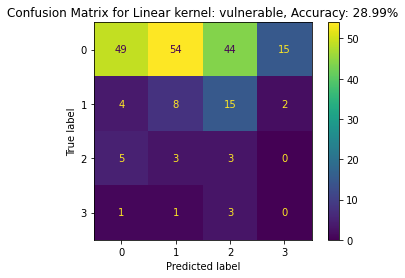

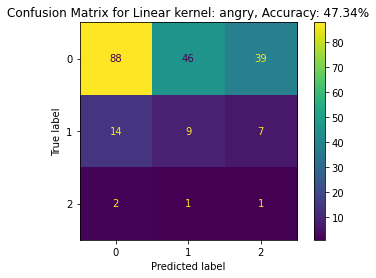

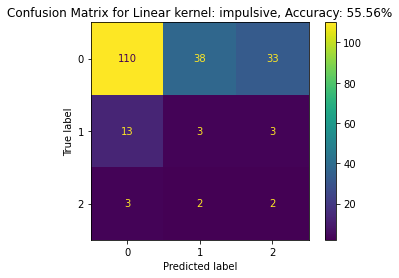

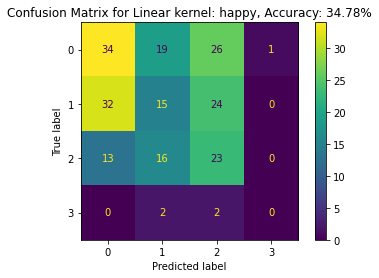

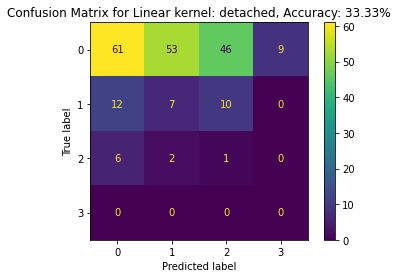

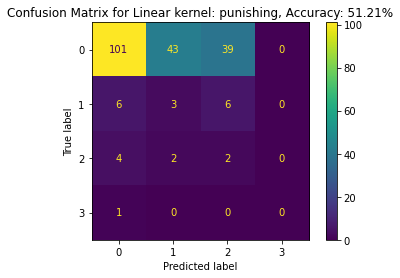

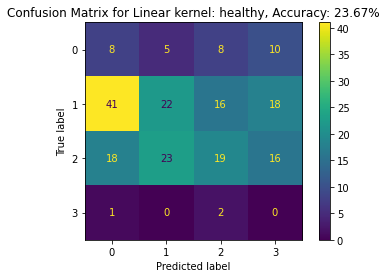

In [5]:
def svm_ordinal_lin():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_average_for_each_label(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
   
    scaled_train = svm_scaler(x_train)
    svm_rbf_models = multi_label_classification(x_train, y_train, scaled_train, 'rbf')
    svm_lin_models = multi_label_classification(x_train, y_train, scaled_train, 'linear')
    svm_poly_models = multi_label_classification(x_train, y_train, scaled_train, 'poly')

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)
    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    print("y_test.shape: ", y_test.shape)

    print("RBF")
    svm_rbf_out, svm_rbf_perf = multi_label_predict(svm_rbf_models, x_test, y_train, y_test, scaled_train, 'rbf')
    print("Linear")
    svm_lin_out, svm_lin_perf = multi_label_predict(svm_lin_models, x_test, y_train, y_test, scaled_train, 'linear')
    print("Poly")
    svm_poly_out, svm_poly_perf = multi_label_predict(svm_poly_models, x_test, y_train, y_test, scaled_train, 'poly')

    def my_svm(test_X,test_y):
        my_svm_out, my_svm_perf=multi_label_predict(svm_lin_models,test_X,y_train,test_y,scaled_train, 'poly')
        return gof_spear(my_svm_out,test_y)

    print(pd.DataFrame(data=[svm_rbf_perf,svm_lin_perf,svm_poly_perf],index=['rbf','lin','poly'],columns=['svm']))
    # print(classification_report(y_test, schema_test_pred, target_names=schemas))
    print(pd.DataFrame(data=gof_spear(svm_lin_out, y_test),index=schemas,columns=['estimate']))
    output_SVC = my_svm(x_test, y_test)
    print('SVM Classification Prediction')
    print(pd.DataFrame(data=output_SVC,index=schemas,columns=['estimate']))

    preds= multi_label_predict(svm_lin_models,x_test,y_train,y_test,scaled_train, 'linear')[0]
    for i in range(len(schemas)):
        mat = confusion_matrix(y_true=y_test[:,i], y_pred=preds[:,i])
        disp = ConfusionMatrixDisplay(confusion_matrix=mat).plot()
        plt.title('Confusion Matrix for Linear kernel: ' + schemas[i] + ", Accuracy: " + "{:.2%}".format(accuracy_score(y_true=y_test[:,i], y_pred=preds[:,i])))
        plt.savefig('../plots/svm/ordinal/Linear/confusion ' + str(schemas[i]))
        plt.show()


svm_ordinal_lin()